## 1. Structure Dataset

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
# funcs stolen from nyu deep learning course
from res.sequential_tasks import pad_sequences, to_categorical
import os

In [2]:
data_path = '/Users/evanrussek/Dropbox/Griffiths_Lab_Stuff/Data/RNNs/optimal_fixation_sims'
# os.path.join(to_save_folder, file_name)
train_file_idxs = range(1,16)
test_file_idxs = range(16,31)

train_files = [os.path.join(data_path, str(i) + '.json') for i in train_file_idxs]
test_files = [os.path.join(data_path, str(i) + '.json') for i in test_file_idxs]

a = [json.load(open(train_files[i])) for i in range(15)]
train_trials = [item for sublist in a for item in sublist]
del a
train_data_sim = train_trials[:int(1e6)]

test_trials = json.load(open(test_files[0]))
test_data_sim = test_trials[:int(1e5)]



In [44]:
np.unique(np.array([train_trials[i]['value'] for i in range(len(train_trials))]))

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [45]:
def gen_batch_data(batch_size, batch_idx, sim_data):
# can you also pass the index on which this starts... 
#sim_data = train_data_sim
#batch_idx = 0
#batch_size = 32

    """
    Create sequence and target data for a batch

    Input: 
        batch_size: number of trials to include in batch
        batch_idx: index of data
        sim_data: list of dicts, where each dict has 'values', 'fixations', and 'choice'

    Returns:
        a tuple, (batch_data, batch_targets)
        batch_data is 3d array: batch_size x sequence_size x one-hot categorical encoding (3 here)
        batch_targets is 2d array: 
    """

    # filter list of trials that are in this batch
    batch_sim_data = sim_data[batch_idx*batch_size:((batch_idx+1)*(batch_size))]

    ## generate sequences of fixations + choice

    # all sequences in the batch, attended item is coded as idx (as 0, 1, 2)
    batch_sequences_idx = [trial_data['fixations'] + [trial_data['choice']-1] for trial_data in batch_sim_data]

    # all sequences in the batch, attended item coded as one-hot categorical: e.g. 0: [1,0,0] 1: [0,1,0], [0,0,1]
    batch_sequences_cat = [[to_categorical(x, num_classes = 3) for x in this_sequence] for this_sequence in batch_sequences_idx]

    # pad front of each sequence with n x [0,0,0] so that all seqeunces are same length
    batch_data = pad_sequences(batch_sequences_cat)
    batch_data = batch_data.astype('float32')

    ## generate sequences of targets 
    batch_targets = np.array([trial_data['value'] for trial_data in batch_sim_data], dtype = 'float32')
    # extend this to match the size of the batch_data
    
    
    # all sequences in the batch, attended item is coded as idx (as 0, 1, 2)
    batch_fixation_sequences_idx = [trial_data['fixations'] for trial_data in batch_sim_data]
    batch_choices_idx = [trial_data['choice'] - 1 for trial_data in batch_sim_data]

    # first 3 are fixation, last is choice...
    batch_sequences_cat = [[to_categorical(x, num_classes = 6) for x in this_sequence] for this_sequence in batch_sequences_idx]

    # now append to each of these the choice info - the choice gets it's own channel (of 3)
    batch_sequences_cat_w_choices = [batch_sequences_cat[i] + [to_categorical(3 + batch_choices_idx[i], num_classes = 6)] for i in range(len(batch_sequences_cat))]
    batch_data = pad_sequences(batch_sequences_cat_w_choices)
    batch_data = batch_data.astype('float32')

    batch_targets_init = np.array([trial_data['value'] for trial_data in batch_sim_data], dtype = 'float32')
    batch_targets_cont = [np.repeat([batch_targets_init[i]],len(batch_sequences_cat_w_choices[i]),axis=0) for i in range(len(batch_sequences_cat_w_choices))]
    #batch_targets_cont = [np.repeat([batch_targets_init[i]],len(batch_sequences_cat[i]),axis=0) for i in range(len(batch_sequences_cat))]

    batch_targets = pad_sequences(batch_targets_cont)
    batch_targets = batch_targets.astype('float32')
    
    first_fixations = np.array([np.where(batch_targets[i,:,:] != [0,0,0])[0][0] for i in range(batch_targets.shape[0])])
    

    return (batch_data, batch_targets)

In [46]:
def gen_batch_data_choice_only(batch_size, batch_idx, sim_data):
    # filter list of trials that are in this batch
    batch_sim_data = sim_data[batch_idx*batch_size:((batch_idx+1)*(batch_size))]

    # all sequences in the batch, attended item is coded as idx (as 0, 1, 2)
    batch_choices_idx = [trial_data['choice'] - 1 for trial_data in batch_sim_data]

    batch_data = to_categorical(batch_choices_idx)
    batch_data = batch_data.astype('float32')

    batch_targets = np.array([trial_data['value'] for trial_data in batch_sim_data], dtype = 'float32')
    batch_targets= batch_targets.astype('float32')
    return (batch_data, batch_targets)


In [47]:
example_batch = gen_batch_data(32, 0, train_data_sim) # batch size = 32, idx = 0
print(f'The return type is a {type(example_batch)} with length {len(example_batch)}.')
print(f'The first item in the tuple is the batch of sequences with shape {example_batch[0].shape}.')
print(f'The first element in the batch of sequences is:\n {example_batch[0][0, :, :]}')
print(f'The second item in the tuple is the corresponding batch of targets with shape {example_batch[1].shape}.')
print(f'The first element in the batch of targets is:\n {example_batch[1][0, :]}')
# print(f'The first element in fixations is:\n {example_batch[2][0]}')


The return type is a <class 'tuple'> with length 2.
The first item in the tuple is the batch of sequences with shape (32, 86, 6).
The first element in the batch of sequences is:
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [

In [48]:
example_batch = gen_batch_data_choice_only(32, 0, train_data_sim) # batch size = 32, idx = 0
print(f'The return type is a {type(example_batch)} with length {len(example_batch)}.')
print(f'The first item in the tuple is the batch of sequences with shape {example_batch[0].shape}.')
print(f'The first element in the batch of sequences is:\n {example_batch[0][0, :]}')
print(f'The second item in the tuple is the corresponding batch of targets with shape {example_batch[1].shape}.')
print(f'The first element in the batch of targets is:\n {example_batch[1][0, :]}')

The return type is a <class 'tuple'> with length 2.
The first item in the tuple is the batch of sequences with shape (32, 3).
The first element in the batch of sequences is:
 [1. 0. 0.]
The second item in the tuple is the corresponding batch of targets with shape (32, 3).
The first element in the batch of targets is:
 [4. 2. 3.]


## 2. Defining the Model

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Set the random seed for reproducible results

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        # This just calls the base class constructor
        super().__init__()
        # Neural network layers assigned as attributes of a Module subclass
        # have their parameters registered for training automatically.
        self.rnn = torch.nn.RNN(input_size, hidden_size, nonlinearity='relu', batch_first=True)
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # The RNN also returns its hidden state but we don't use it.
        # While the RNN can also take a hidden state as input, the RNN
        # gets passed a hidden state initialized with zeros by default.
        h = self.rnn(x)[0]
        x = self.linear(h)
        return x
    
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h = self.lstm(x)[0]
        x = self.linear(h)
        return x
    
    def get_states_across_time(self, x):
        h_c = None
        h_list, c_list = list(), list()
        with torch.no_grad():
            for t in range(x.size(1)):
                h_c = self.lstm(x[:, [t], :], h_c)[1]
                h_list.append(h_c[0])
                c_list.append(h_c[1])
            h = torch.cat(h_list)
            c = torch.cat(c_list)
        return h, c
    
class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.input_hidden = nn.Linear(input_size, hidden_size)
        self.hidden_output = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        ha = self.input_hidden(x)
        hb = F.relu(ha)
        o = self.hidden_output(hb)
        return o


## 3. Defining the Training Loop

In [50]:
def train(model, train_sim_data, criterion, optimizer, device, batch_size, n_total_seq):
    # Set the model to training mode. This will turn on layers that would
    # otherwise behave differently during evaluation, such as dropout.
    model.train()

    # What metric to store?
    # num_correct = 0

    # Iterate over every batch of sequences. Note that the length of a data generator
    # is defined as the number of batches required to produce a total of roughly 1000
    # sequences given a batch size.
        
    # how many batches
    n_batches = int(np.round(n_total_seq/batch_size));
    
    for batch_idx in range(n_batches):

        # Request a batch of sequences and class labels, convert them into tensors
        # of the correct type, and then send them to the appropriate device.
        #data, target = train_data_gen[batch_idx] # just alter this to the function that produces the data?
        data, target = gen_batch_data(batch_size, batch_idx, train_sim_data)
        
        data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

        # Perform the forward pass of the model
        output = model(data)  # Step ①

        # Pick only the output corresponding to last sequence element (input is pre padded)
        output = output[:, -1, :]

        # Compute the value of the loss for this batch. For loss functions like CrossEntropyLoss,
        # the second argument is actually expected to be a tensor of class indices rather than
        # one-hot encoded class labels. One approach is to take advantage of the one-hot encoding
        # of the target and call argmax along its second dimension to create a tensor of shape
        # (batch_size) containing the index of the class label that was hot for each sequence.
        
        # for some reason target is an int, and dosn't match the output which is float32
        target = target.to(torch.float32)
        loss = criterion(output, target)  # Step ②

        # Clear the gradient buffers of the optimized parameters.
        # Otherwise, gradients from the previous batch would be accumulated.
        optimizer.zero_grad()  # Step ③

        loss.backward()  # Step ④

        optimizer.step()  # Step ⑤
        
        #y_pred = output.argmax(dim=
        
        # this is wrong since we're doing regression...
        #num_correct += (y_pred == target).sum().item()

    #return num_correct, loss.item()
    return loss.item()

## 4. Defining the Testing Loop

In [57]:
# Define the testing loop
def test(model, test_sim_data, criterion, device, batch_size, n_total_seq, gen_batch_data):
    # Set the model to evaluation mode. This will turn off layers that would
    # otherwise behave differently during training, such as dropout.
    model.eval()

    # Store the number of sequences that were classified correctly
    # num_correct = 0
    
    n_total_seq = 1000

    n_batches = int(np.round(n_total_seq / batch_size));

    loss_res = np.zeros((n_batches, 1), dtype=float)

    # A context manager is used to disable gradient calculations during inference
    # to reduce memory usage, as we typically don't need the gradients at this point.
    with torch.no_grad():
        for batch_idx in range(n_batches):
            data, target = gen_batch_data(batch_size, batch_idx, test_sim_data)
            data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

            output = model(data)
            
            to_keep = target != 0
            target = target[to_keep]
            output = output[to_keep]
            
            
            # Pick only the output corresponding to last sequence element (input is pre padded)
            # output = output[:, -1, :]

            # target = target.argmax(dim=1)
            loss = criterion(output, target)  # is this just for the last batch?

            # store the loss
            loss_res[batch_idx] = loss.item()

            # y_pred = output.argmax(dim=1)
            # num_correct += (y_pred == target).sum().item()

    # return num_correct, loss.item()
    # print(loss_res)
    # print(loss.item())

    return np.mean(loss_res)  # loss.item()

In [51]:
from IPython import display
from IPython.display import clear_output


def train_with_int_tests(model, train_sim_data, test_sim_data, criterion, optimizer, device, batch_size, n_total_seq, gen_batch_data, model_name = ""):
    # Set the model to training mode. This will turn on layers that would
    # otherwise behave differently during evaluation, such as dropout.
    model.train()
    
    # What metric to store?
    # num_correct = 0

    # Iterate over every batch of sequences. Note that the length of a data generator
    # is defined as the number of batches required to produce a total of roughly 1000
    # sequences given a batch size.
        
    # how many batches
    n_batches = int(np.round(n_total_seq/batch_size));
    
    loss_res = []
    train_loss_res = []
    batch_num = []

    for batch_idx in range(n_batches):

        # Request a batch of sequences and class labels, convert them into tensors
        # of the correct type, and then send them to the appropriate device.
        #data, target = train_data_gen[batch_idx] # just alter this to the function that produces the data?
        data, target = gen_batch_data(batch_size, batch_idx, train_sim_data)
        
        # this needs to change... 
        data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

        # Perform the forward pass of the model
        output = model(data)  # Step ①

        
        # for some reason target is an int, and dosn't match the output which is float32
        target = target.to(torch.float32)
        
        # remove padding (nicely, this is just 0's)
        to_keep = target != 0
        target = target[to_keep]
        output = output[to_keep]
        
        # need to re-write this function... 
        loss = criterion(output, target)  # Step ②

        # Clear the gradient buffers of the optimized parameters.
        # Otherwise, gradients from the previous batch would be accumulated.
        optimizer.zero_grad()  # Step ③

        loss.backward()  # Step ④

        optimizer.step()  # Step ⑤
        
        if ((batch_idx % 250) == 0) & (batch_idx > 0):
            test_loss = test(model, test_data_sim, criterion, device, batch_size, n_total_seq, gen_batch_data)
            loss_res.append(test_loss)
            
            train_loss_res.append(loss.item())
            batch_num.append(batch_idx+1)
            
            clear_output(wait=False)
            plt.figure(figsize=(5,5))
            plt.plot(np.arange(1,len(loss_res)+1)*250*32, loss_res)
            #plt.plot(range(len(train_loss_res)), train_loss_res)
            plt.xlabel('# train examples')
            plt.ylabel('MSE')
            plt.title(model_name)
            plt.show();

            print('batch num' + str(batch_idx) + ' loss: ' + str(test_loss))

    #return num_correct, loss.item()
    return model, loss_res, batch_num#loss.item()

In [39]:
batch_size     = 32
n_total_seq = 1e6
n_batches = int(np.round(n_total_seq/batch_size));
n_tests = int(np.ceil(n_batches/250)) - 1

input_size  = 6 # this is the length of the input vector? #train_data_gen.n_symbols
hidden_size = 50
output_size = 3 # this is the leågth of the output vector #train_data_gen.n_classes
model       = SimpleLSTM(input_size, hidden_size, output_size)
criterion   = torch.nn.MSELoss() # torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
# optimizer   = torch.optim.Adam(model.parameters(), lr=0.00304)
max_epochs  = 10
device = torch.device('cpu')#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')\


train_sim_data = train_data_sim

# Set the model to training mode. This will turn on layers that would
# otherwise behave differently during evaluation, such as dropout.
model.train()

# What metric to store?
# num_correct = 0

# Iterate over every batch of sequences. Note that the length of a data generator
# is defined as the number of batches required to produce a total of roughly 1000
# sequences given a batch size.

# how many batches
n_batches = int(np.round(n_total_seq/batch_size));

loss_res = []
train_loss_res = []
batch_num = []

#for batch_idx in range(n_batches):
batch_idx=0

# Request a batch of sequences and class labels, convert them into tensors
# of the correct type, and then send them to the appropriate device.
#data, target = train_data_gen[batch_idx] # just alter this to the function that produces the data?
data, target, first_fix = gen_batch_data(batch_size, batch_idx, train_sim_data)

# this needs to change... 
data, target, first_fix = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device), torch.from_numpy(first_fix).long().to(device)

# Perform the forward pass of the model
output = model(data)  # Step ①

# Pick only the output corresponding to last sequence element (input is pre padded)
# output = output[:, -1, :]

# Compute the value of the loss for this batch. For loss functions like CrossEntropyLoss,
# the second argument is actually expected to be a tensor of class indices rather than
# one-hot encoded class labels. One approach is to take advantage of the one-hot encoding
# of the target and call argmax along its second dimension to create a tensor of shape
# (batch_size) containing the index of the class label that was hot for each sequence.

# for some reason target is an int, and dosn't match the output which is float32
target = target.to(torch.float32)

to_keep = target != 0
target = target[to_keep]
output = output[to_keep]

# just go through each sequence 
# need to re-write this function... 
loss = criterion(output, target)  # Step ②

# Clear the gradient buffers of the optimized parameters.
# Otherwise, gradients from the previous batch would be accumulated.
optimizer.zero_grad()  # Step ③

loss.backward()  # Step ④

optimizer.step()  # Step ⑤

In [37]:
to_keep = target != 0
target[to_keep]
output[to_keep]

tensor([-0.1392,  0.0765,  0.1323,  ..., -0.1095,  0.1014,  0.1363],
       grad_fn=<IndexBackward0>)

## Run the LSTM

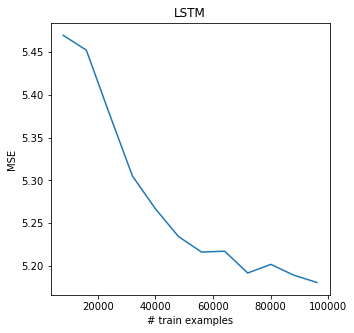

batch num3000 loss: 5.180634229413925
--- 83.438148021698 seconds ---


In [67]:
import time

# Setup the training and test data generators
batch_size     = 32
n_total_seq = 1e5
n_batches = int(np.round(n_total_seq/batch_size));
n_tests = int(np.ceil(n_batches/250)) - 1

n_runs = 5
LSTM_run_losses = np.zeros((n_runs, n_tests))
for run_idx in range(n_runs):
    torch.manual_seed(run_idx)

    print(run_idx)

    # Setup the RNN and training settings
    input_size  = 6 # this is the length of the input vector? #train_data_gen.n_symbols
    hidden_size = 50
    output_size = 3 # this is the leågth of the output vector #train_data_gen.n_classes
    model       = SimpleLSTM(input_size, hidden_size, output_size)
    criterion   = torch.nn.MSELoss() # torch.nn.CrossEntropyLoss()
    optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
    # optimizer   = torch.optim.Adam(model.parameters(), lr=0.00304)
    max_epochs  = 10
    device = torch.device('cpu')#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    # Train the model›
    # model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs)
    start_time = time.time()
    # model_LSTM = train_and_test(model, train_data_sim, test_data_sim, criterion, optimizer, max_epochs, batch_size, n_total_seq, verbose=True, model_name = 'LSTM')
    device = torch.device('cpu')#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model_LSTM, loss_res, LSTM_batch_num = train_with_int_tests(model, train_data_sim, test_data_sim, criterion, optimizer, device, batch_size, n_total_seq, gen_batch_data, model_name='LSTM')
    LSTM_run_losses[run_idx,:] = loss_res
    print("--- %s seconds ---" % (time.time() - start_time))

In [425]:
 int(np.ceil(n_batches/250)) - 1

124

Text(0, 0.5, 'MSE (average over 5 runs)')

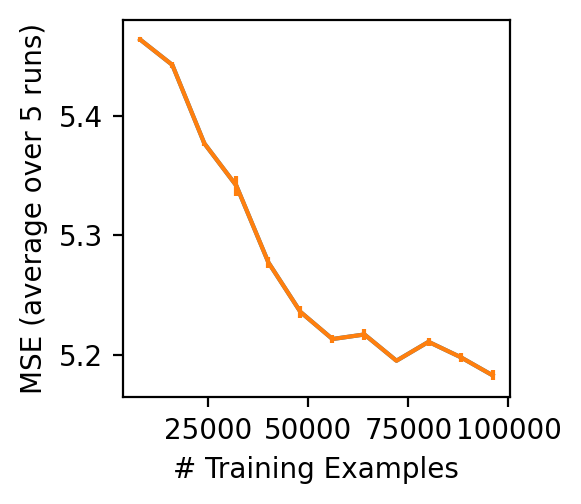

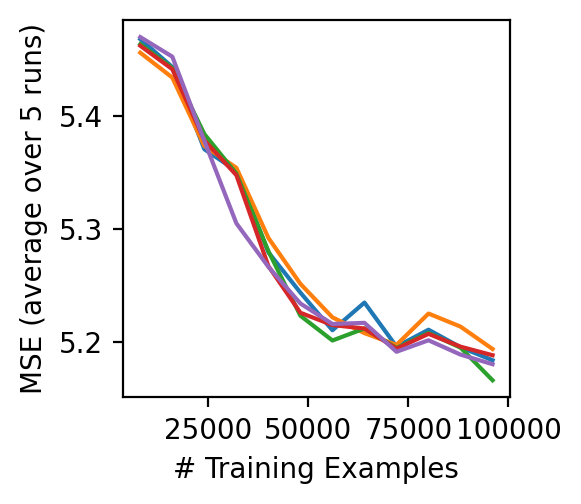

In [71]:
fig, ax = plt.subplots(1,figsize=(2.5,2.5),dpi=200)
ax.plot(np.array(LSTM_batch_num)*32, np.mean(LSTM_run_losses,0))
ax.errorbar(np.array(LSTM_batch_num)*32, np.mean(LSTM_run_losses,0),yerr=np.std(LSTM_run_losses,0)/np.sqrt(5))
ax.set_xlabel('# Training Examples')
ax.set_ylabel('MSE (average over 5 runs)')


fig, ax = plt.subplots(1,figsize=(2.5,2.5),dpi=200)
for i in range(5):
    ax.plot(np.array(LSTM_batch_num)*32, LSTM_run_losses[i,:])
ax.set_xlabel('# Training Examples')
ax.set_ylabel('MSE (average over 5 runs)')

#### Run the MLP

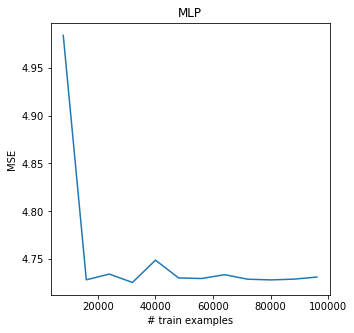

batch num3000 loss: 4.731320335019019
--- 2.7542788982391357 seconds ---


In [416]:
# Setup the training and test data generators
batch_size     = 32
n_total_seq = 1e6
n_batches = int(np.round(n_total_seq/batch_size));
n_tests = int(np.floor(n_batches/250))

n_runs = 10
MLP_run_losses = np.zeros((n_runs, n_tests))
for run_idx in range(n_runs):
    
    # Setup the RNN and training settings
    input_size  = 3 # this is the length of the input vector? #train_data_gen.n_symbols
    hidden_size = 50
    output_size = 3 # this is the leågth of the output vector #train_data_gen.n_classes
    model       = SimpleMLP(input_size, hidden_size, output_size)
    criterion   = torch.nn.MSELoss() # torch.nn.CrossEntropyLoss()
    optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
    # optimizer   = torch.optim.Adam(model.parameters(), lr=0.00304)
    max_epochs  = 10
    device = torch.device('cpu')#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


    # Train the model›
    # model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs)
    start_time = time.time()
    # model_LSTM = train_and_test(model, train_data_sim, test_data_sim, criterion, optimizer, max_epochs, batch_size, n_total_seq, verbose=True, model_name = 'LSTM')
    device = torch.device('cpu')#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model_MLP, loss_res, batch_num = train_with_int_tests(model, train_data_sim, test_data_sim, criterion, optimizer, device, batch_size, n_total_seq, gen_batch_data_choice_only,model_name='MLP')
    MLP_run_losses[run_idx,:] = loss_res
    print("--- %s seconds ---" % (time.time() - start_time))

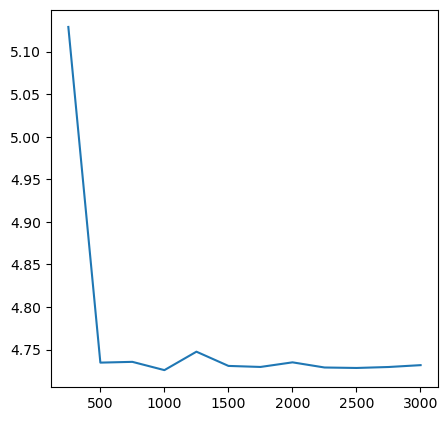

In [417]:
fig, ax = plt.subplots(1,figsize=(5,5),dpi=100)
ax.plot(MLP_batch_num, np.mean(MLP_run_losses,0))

In [418]:
# MLP_run_losses

array([[5.05247456, 4.72887842, 4.73506992, 4.72626009, 4.7505078 ,
        4.73071909, 4.73033454, 4.7349431 , 4.72969307, 4.72851447,
        4.72912039, 4.73161277],
       [5.10863739, 4.73397719, 4.73593975, 4.7257931 , 4.74729532,
        4.73075965, 4.72933891, 4.73561884, 4.7290553 , 4.72824646,
        4.72971319, 4.73211255],
       [5.08877428, 4.73052292, 4.73636217, 4.72623747, 4.74665976,
        4.73163445, 4.72971873, 4.73683659, 4.72876289, 4.72855996,
        4.72979893, 4.73244918],
       [5.29493378, 4.74667125, 4.73538903, 4.72562658, 4.74704859,
        4.7310299 , 4.72941914, 4.73396047, 4.72904704, 4.72840331,
        4.72961866, 4.73152178],
       [5.03297943, 4.73072663, 4.73612312, 4.72609797, 4.74804435,
        4.73104469, 4.72973813, 4.73594383, 4.72865758, 4.72840092,
        4.72955482, 4.73179143],
       [5.16677083, 4.73175038, 4.73578164, 4.7257077 , 4.74730212,
        4.7304909 , 4.72943029, 4.73561387, 4.72859029, 4.72810727,
        4.729405  ,

In [63]:
def test_record_each_output(model, test_sim_data, criterion, device, batch_size, n_total_seq, gen_batch_data,out_idx, choice_only=False):
    # Set the model to evaluation mode. This will turn off layers that would
    # otherwise behave differently during training, such as dropout.
    
    # print(choice_only)
    model.eval()

    # Store the number of sequences that were classified correctly
    # num_correct = 0

    n_batches = int(np.round(n_total_seq/batch_size));

    output_all = np.zeros((0,3))
    target_all = np.zeros((0,3))

    # A context manager is used to disable gradient calculations during inference
    # to reduce memory usage, as we typically don't need the gradients at this point.
    with torch.no_grad():
        for batch_idx in range(n_batches):
            data, target = gen_batch_data(batch_size, batch_idx, test_sim_data)
            data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

            output = model(data)
            # Pick only the output corresponding to last sequence element (input is pre padded)
            if not choice_only:
                output = output[:, -out_idx, :]
                target = target[:,-out_idx,:]

            output_all = np.concatenate((output_all, output.numpy()))
            target_all = np.concatenate((target_all, target.numpy()))

    return (output_all, target_all)



Text(0.5, 1.0, 'LSTM Performance, MSE: 4.24 , r: 0.59 ')

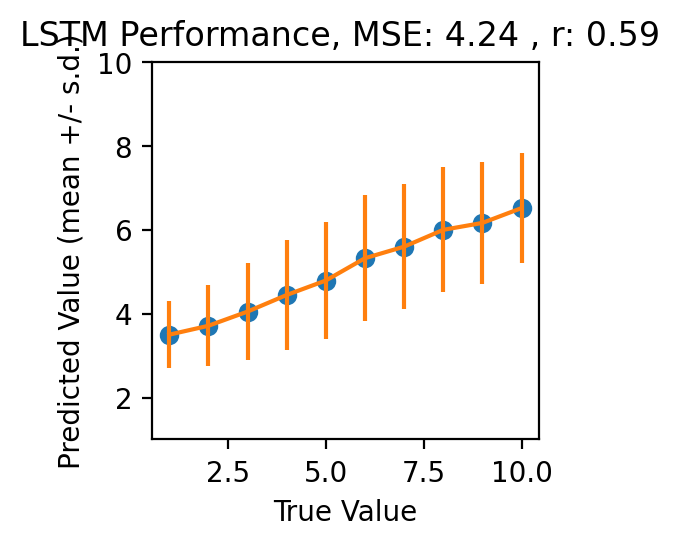

In [65]:
n_total_seq_vis = 1e4
output_all_LSTM, target_all_LSTM = test_record_each_output(model_LSTM, test_data_sim, criterion, device, batch_size, n_total_seq_vis,gen_batch_data, 1)
output_flat = output_all_LSTM.flatten()
target_flat = target_all_LSTM.flatten()

r = np.round(np.corrcoef(output_flat, target_flat)[1][0], decimals = 2)
mse = np.round(np.mean(np.power(output_flat - target_flat,2)), decimals=2)
target_flat_round = np.round(target_flat)
mean_estimates = np.zeros(10)
std_estimates = np.zeros(10)
for i in range(1,11):
    mean_estimates[i-1] = np.mean(output_flat[target_flat_round == i])
    std_estimates[i-1] = np.std(output_flat[target_flat_round == i])

fix,ax = plt.subplots(1,figsize = (2.5,2.5), dpi = 200)
ax.plot(range(1,11), mean_estimates, 'o')
ax.errorbar(range(1,11), mean_estimates, yerr = std_estimates)
ax.set_ylim([1,10])
ax.set_xlabel('True Value')
ax.set_ylabel('Predicted Value (mean +/- s.d.)')
ax.set_title('LSTM Performance, MSE: {} , r: {} '.format(mse,r))

Text(0, 0.5, 'r: prediction vs target')

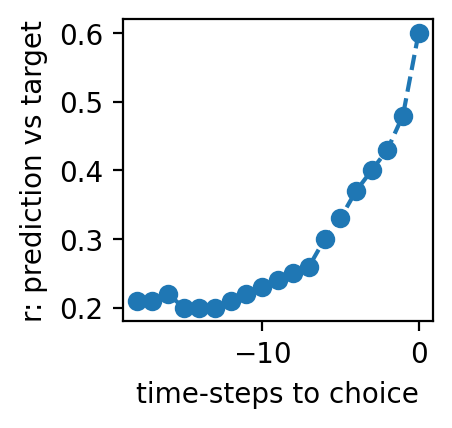

In [66]:
# can you record from starting at end and moving backward... 

n_back_vals = np.arange(1,20)
r_by_n_back = np.zeros(len(n_back_vals))

n_total_seq_vis = 1e3

for nb_idx, nb in enumerate(n_back_vals):
    output_all_LSTM, target_all_LSTM = test_record_each_output(model_LSTM, test_data_sim, criterion, device, batch_size, n_total_seq_vis,gen_batch_data,nb)
    output_flat = output_all_LSTM.flatten()
    target_flat = target_all_LSTM.flatten()
    output_flat = output_flat[target_flat != 0]
    target_flat = target_flat[target_flat != 0]

    r = np.round(np.corrcoef(output_flat, target_flat)[1][0], decimals = 2)
    r_by_n_back[nb_idx] = r
    
fig,ax = plt.subplots(1,figsize=(2,2),dpi=200)
ax.plot(-1*n_back_vals+1,r_by_n_back, '--o')
ax.set_xlabel('time-steps to choice')
ax.set_ylabel('r: prediction vs target')

True


Text(0.5, 1.0, 'MLP Performance, MSE: 4.73 , r: 0.5 ')

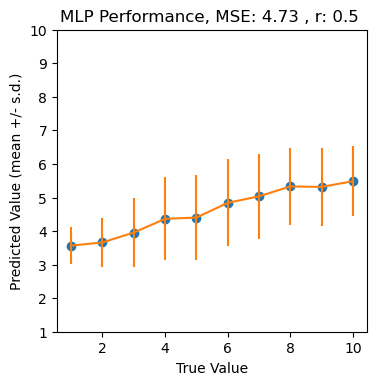

In [423]:
n_total_seq_vis = 1e3
output_all_MLP, target_all_MLP = test_record_each_output(model_MLP, test_data_sim, criterion, device, batch_size, n_total_seq_vis, gen_batch_data_choice_only,0, choice_only=True)
output_flat = output_all_MLP.flatten()
target_flat = target_all_MLP.flatten()

r = np.round(np.corrcoef(output_flat, target_flat)[1][0], decimals = 2)
mse = np.round(np.mean(np.power(output_flat - target_flat,2)), decimals=2)
target_flat_round = np.round(target_flat)
mean_estimates = np.zeros(10)
std_estimates = np.zeros(10)
for i in range(1,11):
    mean_estimates[i-1] = np.mean(output_flat[target_flat_round == i])
    std_estimates[i-1] = np.std(output_flat[target_flat_round == i])

fix,ax = plt.subplots(1,figsize = (4,4), dpi = 100)
ax.plot(range(1,11), mean_estimates, 'o')
ax.errorbar(range(1,11), mean_estimates, yerr = std_estimates)
ax.set_ylim([1,10])
ax.set_xlabel('True Value')
ax.set_ylabel('Predicted Value (mean +/- s.d.)')
ax.set_title('MLP Performance, MSE: {} , r: {} '.format(mse,r))

In [401]:
output_all_MLP[:5,:], target_all_MLP[:5,:]

(array([[6.0756073 , 3.35752535, 3.46393704],
        [3.52752924, 3.37813091, 6.04007292],
        [6.0756073 , 3.35752535, 3.46393704],
        [3.42318654, 5.99342203, 3.50141191],
        [6.0756073 , 3.35752535, 3.46393704]]),
 array([[4., 2., 3.],
        [1., 3., 7.],
        [4., 1., 3.],
        [5., 9., 6.],
        [7., 1., 5.]]))

In [394]:
choice_only = False

print(True)

SyntaxError: invalid syntax (144242808.py, line 1)

### Does it get the correct ordering?

In [446]:
output_all_LSTM, target_all_LSTM = test_record_each_output(model_LSTM, test_data_sim, criterion, device, batch_size, n_total_seq_vis,gen_batch_data,1)


output_max_item = output_all_LSTM.argmax(axis=1)
target_max_item = target_all_LSTM.argmax(axis=1)
pct_correct_max = np.sum(output_max_item == target_max_item)/len(output_max_item)

print('LSTM guesses correct max {}% of trials'.format(100*np.round(pct_correct_max,decimals=2)))

output_min_item = output_all_LSTM.argmin(axis=1)
target_min_item = target_all_LSTM.argmin(axis=1)
pct_correct_min = np.sum(output_min_item == target_min_item)/len(output_min_item)

print('LSTM guesses correct min {}% of trials'.format(100*np.round(pct_correct_min,decimals=2)))

LSTM guesses correct max 74.0% of trials
LSTM guesses correct min 53.0% of trials


In [447]:
# for targets 
target_orders = np.ones(target_all_LSTM.shape)
target_max_item = target_all_LSTM.argmax(axis=1)
target_orders[range(target_orders.shape[0]),target_max_item]=2
target_min_item = target_all_LSTM.argmin(axis=1)
target_orders[range(target_orders.shape[0]),target_min_item]=0

output_orders = np.ones(output_all_LSTM.shape)
output_max_item = output_all_LSTM.argmax(axis=1)
output_orders[range(output_orders.shape[0]),target_max_item]=2
output_min_item = output_all_LSTM.argmin(axis=1)
output_orders[range(target_orders.shape[0]),target_min_item]=0

prop_max_g_mid = np.sum(output_all_LSTM[target_orders==2]>output_all_LSTM[target_orders==1])/output_all_LSTM.shape[0]
prop_mid_g_min = np.sum(output_all_LSTM[target_orders==1]>output_all_LSTM[target_orders==0])/output_all_LSTM.shape[0]
prop_max_g_min = np.sum(output_all_LSTM[target_orders==2]>output_all_LSTM[target_orders==0])/output_all_LSTM.shape[0]
prop_correct_order = np.sum((output_all_LSTM[target_orders==2]>output_all_LSTM[target_orders==1])&(output_all_LSTM[target_orders==1]>output_all_LSTM[target_orders==0]))/output_all_LSTM.shape[0]

prop_correct_max = np.sum(target_max_item == output_max_item)/len(target_max_item)
prop_correct_min = np.sum(target_min_item == output_min_item)/len(target_min_item)

print('correct order {}% of trials'.format(100*np.round(prop_correct_order,decimals=2)))
print('max > mid {}% of trials'.format(100*np.round(prop_max_g_mid,decimals=2)))
print('mid > min {}% of trials'.format(100*np.round(prop_mid_g_min,decimals=2)))
print('max > min {}% of trials'.format(100*np.round(prop_max_g_min,decimals=2)))
print('correct max {}% of trials'.format(100*np.round(prop_correct_max,decimals=2)))
print('correct min {}% of trials'.format(100*np.round(prop_correct_min,decimals=2)))


correct order 41.0% of trials
max > mid 77.0% of trials
mid > min 62.0% of trials
max > min 85.0% of trials
correct max 74.0% of trials
correct min 53.0% of trials


In [ ]:
# how well does it get the difference between max and min 

In [57]:
mean_estimates

array([       nan,        nan, 4.20361695, 4.59310827, 5.12080646,
       5.51035056, 5.77384573, 6.13292855, 6.28513572, 6.52798245])

In [52]:
max_targets

array([4., 7., 4., ..., 4., 3., 8.])